# 2022-10-24 • N-to-1 with lognormal inputs

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
@time using MyToolbox
@time using SpikeWorks
@time using Sciplotlib
@time using VoltoMapSim

  6.076024 seconds (3.39 M allocations: 212.208 MiB, 2.41% gc time, 32.60% compilation time: 61% of which was recompilation)
  4.639393 seconds (2.65 M allocations: 159.224 MiB, 2.82% gc time, 32.20% compilation time: 86% of which was recompilation)
 23.643910 seconds (13.39 M allocations: 754.670 MiB, 3.50% gc time, 56.14% compilation time: 62% of which was recompilation)
 13.120539 seconds (9.23 M allocations: 595.361 MiB, 4.11% gc time, 2.81% compilation time: 16% of which was recompilation)


## Start

### Neuron-model parameters

In [4]:
@typed begin
    # Izhikevich params
    C  =  100    * pF        # Cell capacitance
    k  =    0.7  * (nS/mV)   # Steepness of parabola in v̇(v)
    vₗ = - 60    * mV        # Resting ('leak') membrane potential
    vₜ = - 40    * mV        # Spiking threshold (when no syn. & adaptation currents)
    a  =    0.03 / ms        # Reciprocal of time constant of adaptation current `u`
    b  = -  2    * nS        # (v-vₗ)→u coupling strength
    vₛ =   35    * mV        # Spike cutoff (defines spike time)
    vᵣ = - 50    * mV        # Reset voltage after spike
    Δu =  100    * pA        # Adaptation current inflow on self-spike
    # Conductance-based synapses
    Eₑ =   0 * mV            # Reversal potential at excitatory synapses
    Eᵢ = -80 * mV            # Reversal potential at inhibitory synapses
    τ  =   7 * ms            # Time constant for synaptic conductances' decay
end;

### Simulated variables and their initial values

In [5]:
x₀ = (
    # Izhikevich variables
    v   = vᵣ,      # Membrane potential
    u   = 0 * pA,  # Adaptation current
    # Synaptic conductances g
    gₑ  = 0 * nS,  # = Sum over all exc. synapses
    gᵢ  = 0 * nS,  # = Sum over all inh. synapses
);

### Differential equations:
calculate time derivatives of simulated vars  
(and store them "in-place", in `Dₜ`).

In [6]:
function f!(Dₜ, vars)
    v, u, gₑ, gᵢ = vars

    # Conductance-based synaptic current
    Iₛ = gₑ*(v-Eₑ) + gᵢ*(v-Eᵢ)

    # Izhikevich 2D system
    Dₜ.v = (k*(v-vₗ)*(v-vₜ) - u - Iₛ) / C
    Dₜ.u = a*(b*(v-vₗ) - u)

    # Synaptic conductance decay
    Dₜ.gₑ = -gₑ / τ
    Dₜ.gᵢ = -gᵢ / τ
end;

### Spike discontinuity

In [7]:
has_spiked(vars) = (vars.v ≥ vₛ)

function on_self_spike!(vars)
    vars.v = vᵣ
    vars.u += Δu
end;

### Conductance-based Izhikevich neuron

In [8]:
coba_izh_neuron = NeuronModel(x₀, f!; has_spiked, on_self_spike!);

### More parameters, and input spikers

In [9]:
using SpikeWorks.Units
using SpikeWorks: LogNormal

In [10]:
Δt = 0.1ms      # Sim timestep

sim_duration = 10seconds
sim_duration = 1minute
sim_duration = 10minutes

600

Firing rates λ for the Poisson inputs

In [11]:
fr_distr = LogNormal(median = 4Hz, g = 2)

Distributions.LogNormal{Float64}(μ=1.39, σ=0.693)

In [12]:
@enum NeuronType exc inh

In [13]:
input(;
    N = 100,
    EIratio = 4//1,
    scaling = N,
) = begin
    firing_rates = rand(fr_distr, N)
    input_IDs = 1:N
    inputs = [
        Nto1Input(ID, poisson_SpikeTrain(λ, sim_duration))
        for (ID, λ) in zip(input_IDs, firing_rates)
    ]
    # Nₑ, Nᵢ = groupsizes(EIMix(N, EIratio))
    EImix = EIMix(N, EIratio)
    Nₑ = EImix.Nₑ
    Nᵢ = EImix.Nᵢ
    neuron_type(ID) = (ID ≤ Nₑ) ? exc : inh
    Δgₑ = 60nS / scaling
    Δgᵢ = 60nS / scaling * EIratio
    on_spike_arrival!(vars, spike) =
        if neuron_type(source(spike)) == exc
            vars.gₑ += Δgₑ
        else
            vars.gᵢ += Δgᵢ
        end
    return (;
        firing_rates,
        inputs,
        on_spike_arrival!,
        Nₑ,
    )
end;

In [14]:
using SpikeWorks: Simulation, step!, run!, unpack, newsim,
                  get_new_spikes!, next_spike, index_of_next

In [15]:
new(; kw...) = begin
    ip = input(; kw...)
    s = newsim(coba_izh_neuron, ip.inputs, ip.on_spike_arrival!, Δt)
    (sim=s, input=ip)
end;

In [16]:
s0 = new().sim

Simulation{Nto1System{NeuronModel{NamedTuple{(:v, :u, :gₑ, :gᵢ), NTuple{4, Float64}}, typeof(f!), typeof(has_spiked), typeof(on_self_spike!)}, var"#on_spike_arrival!#7"{Float64, Float64, var"#neuron_type#6"{Int64}}}, CVec{(:v, :u, :gₑ, :gᵢ)}}
Summary: not started
Properties: 
       system: Nto1System, x₀: (v = -0.05, u = 0, gₑ = 0, gᵢ = 0), input feed: 0/299503 spikes processed
           Δt: 0.0001
     duration: 600
  stepcounter: 0/6000000
        state: t = 0 seconds, neuron = vars: (v: -0.05, u: 0, gₑ: 0, gᵢ: 0), Dₜvars: (v: 0, u: 0, gₑ: 0, gᵢ: 0)
          rec: 

v: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], spiketimes: Float64[]


In [17]:
s0.system

Nto1System{NeuronModel{NamedTuple{(:v, :u, :gₑ, :gᵢ), NTuple{4, Float64}}, typeof(f!), typeof(has_spiked), typeof(on_self_spike!)}, var"#on_spike_arrival!#7"{Float64, Float64, var"#neuron_type#6"{Int64}}}
Summary: Nto1System, x₀: (v = -0.05, u = 0, gₑ = 0, gᵢ = 0), input feed: 0/299503 spikes processed
Properties: 
        neuronmodel: vars_t₀: (v: -0.05, u: 0, gₑ: 0, gᵢ: 0), f!: f!, has_spiked: has_spiked, on_self_spike!: on_self_spike!
              input: 0/299503 spikes processed
  on_spike_arrival!: Δgᵢ: 2.4E-09, Δgₑ: 6E-10, neuron_type: 

(Nₑ: 80)


(Look at that parametrization of `on_spike_arrival!` closure :OO)

## Sim

In [18]:
@time s = run!(new().sim)

  2.046088 seconds (12.97 M allocations: 1.022 GiB, 19.90% gc time, 16.45% compilation time)


Simulation{Nto1System{NeuronModel{NamedTuple{(:v, :u, :gₑ, :gᵢ), NTuple{4, Float64}}, typeof(f!), typeof(has_spiked), typeof(on_self_spike!)}, var"#on_spike_arrival!#7"{Float64, Float64, var"#neuron_type#6"{Int64}}}, CVec{(:v, :u, :gₑ, :gᵢ)}}
Summary: completed. 2 spikes/s
Properties: 
       system: Nto1System, x₀: (v = -0.05, u = 0, gₑ = 0, gᵢ = 0), input feed: all 267219 spikes processed
           Δt: 0.0001
     duration: 600
  stepcounter: 6000000 (complete)
        state: t = 600 seconds, neuron = vars: (v: -0.0587, u: 3.52E-12, gₑ: 7.32E-10, gᵢ: 9.52E-10), Dₜvars: (v: 0.0289, u: -1.82E-10, gₑ: -1.06E-07, gᵢ: -1.38E-07)
          rec: v: [-0.0501, -0.0501, -0.0502, -0.0503, -0.0503, -0.0504, -0.0505, -0.0506, -0.0506, -0.0507  …  -0.0588, -0.0588, -0.0588, -0.0588, -0.0587, -0.0587, -0.0587, -0.0587, -0.0587, -0.0587], spiketimes: [0.429, 0.91, 1.35, 2.62, 2.8, 3.02, 3.31, 3.53, 3.72, 4.2  …  596, 597, 597, 597, 598, 598, 598, 598, 599, 600]


(So 3.3 seconds for 10 minute simulation with N=100 inputs)

## Plot

In [19]:
v_rec = s.rec.v;
Nt = s.stepcounter.N;

In [20]:
@time using PyPlot

  0.001532 seconds (348 allocations: 21.750 KiB)


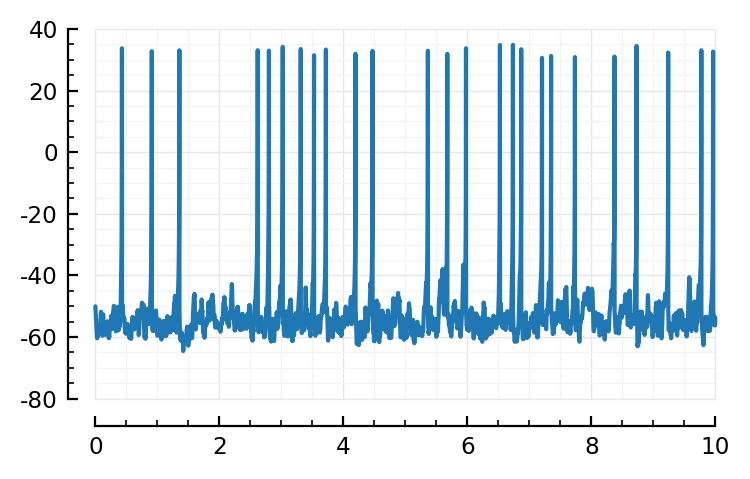

In [21]:
t = linspace(0, sim_duration, Nt)
plotsig(t, v_rec / mV; tlim=[0,10seconds]);

## Multi sim

(These Ns are same as in e.g. https://tfiers.github.io/phd/nb/2022-10-11__Nto1_output_rate__Edit_of_2022-05-02.html)

In [22]:
using SpikeWorks: spikerate

In [23]:
sim_duration/minutes

10

In [24]:
using Printf
print_Δt(t0) = @printf("%.2G seconds\n", time()-t0)
macro time′(ex) :( t0=time(); $(esc(ex)); print_Δt(t0) ) end;

In [25]:
Ns_and_scalings = [
    (5,    2.4),   # => N_inh = 1
    (20,   1.3),
        # orig: 21.
        # But: "pₑ = 0.8 does not divide N = 21 into integer parts"
        # So voila
    (100,  0.8),
    (400,  0.6),
    (1600, 0.5),
    (6500, 0.5),
];
Ns = first.(Ns_and_scalings)
simruns = []
for (N, f) in Ns_and_scalings
    scaling = f*N
    (sim, inp) = new(; N, scaling)
    @show N
    @time′ run!(sim)
    @show spikerate(sim)
    push!(simruns, (; sim, input=inp))
    println()
end

N = 5
2.1 seconds
spikerate(sim) = 1.94

N = 20
2.4 seconds
spikerate(sim) = 1.48

N = 100
2.2 seconds
spikerate(sim) = 3.94

N = 400
2.2 seconds
spikerate(sim) = 5.2

N = 1600
3.7 seconds
spikerate(sim) = 5.02

N = 6500
5 seconds
spikerate(sim) = 5.58



### Disentangle

weird old code. who wrote this?! (oh me)\
what the hell is that naming. "input.inputs"

In [53]:
inp = simruns[1].input
st1 = inp.inputs[1].train.spiketimes;

In [27]:
spiketimes(input::Nto1Input) = input.train.spiketimes;

In [28]:
s = simruns[1].sim
s.rec.v;

In [29]:
vrec(s::Simulation{<:Nto1System}) = s.rec.v;

## Conntest

In [30]:
function conntest_all(inputs, sim)
    f(input) = conntest(spiketimes(input), sim)
    @showprogress map(f, inputs)
end
conntest_all(simrun) = conntest_all(simrun.input.inputs, simrun.sim);

In [31]:
winsize = 1000

calcSTA(sim, spiketimes) =
    calc_STA(vrec(sim), spiketimes, sim.Δt, winsize)

function conntest(spiketimes, sim)
    sta = calcSTA(sim, spiketimes)
    shufs = [
        calcSTA(sim, shuffle_ISIs(spiketimes))
        for _ in 1:100
    ]
    test_conn(ptp_test, sta, shufs)
end;

In [59]:
# @code_warntype calc_STA(vrec(s), st1, s.Δt, winsize)
# all good

In [60]:
conntest_all(simruns[1])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


5-element Vector{NamedTuple{(:predtype, :pval, :pval_type, :Eness), Tuple{Symbol, Float64, String, Float64}}}:
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 1.94)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 2.19)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 2.37)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 1.96)
 (predtype = :inh, pval = 0.01, pval_type = "<", Eness = -1.28)

In [35]:
conntest_all(simruns[3]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


✔

..but, it takes 25 seconds for simrun 3, i.e. for..

In [38]:
length(simruns[3].input.inputs)

100

..inputs.

so extrapolating, the last one would take

In [39]:
25seconds * 6500/100 / minutes

27.1

Almost half an hour.

So this is why we cached and parallel-processed the STA calculation

### Cache STA calc

In [ ]:
cached()

In [82]:
nbname = "2022-10-24__Nto1_with_fixed_lognormal_inputs"
cachekey(N) = "$(nbname)__N=$N";
cachekey(Ns[end])

"2022-10-24__Nto1_with_fixed_lognormal_inputs__N=6500"

In [75]:
function calc_STA_and_shufs(spiketimes, sim)
    realSTA = calcSTA(sim, spiketimes)
    shufs = [
        calcSTA(sim, shuffle_ISIs(spiketimes))
        for _ in 1:100
    ]
    (; realSTA, shufs)
end

"calc_all_STAs_and_shufs"
function calc_all_STAz(inputs, sim)
    f(input) = calc_STA_and_shufs(spiketimes(input), sim)
    @showprogress map(f, inputs)
end
calc_all_STAz(simrun) = calc_all_STAz(unpakk(simrun)...);
unpakk(simrun) = (; simrun.input.inputs, simrun.sim)

out = calc_all_STAz(simruns[1])
print(Base.summary(out))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
5-element Vector{NamedTuple{(:realSTA, :shufs), Tuple{Vector{Float64}, Vector{Vector{Float64}}}}}

In [85]:
calc_all_cached(i) = cached(calc_all_STAz, [simruns[i]], key=cachekey(Ns[i]))

out = []
for i in eachindex(simruns)
    push!(out, calc_all_cached(i))
end;

Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=5.jld2` … done (3.0 s)
Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=20.jld2` … done (0.1 s)
Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=100.jld2` … done (5.6 s)
Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=400.jld2` … done (1.1 s)
Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=1600.jld2` … done (5.0 s)
Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=6500.jld2` … done (47.6 s)


In [89]:
path = raw"C:\Users\tfiers\.phdcache\calc_all_STAz\2022-10-24__Nto1_with_fixed_lognormal_inputs__N=6500.jld2"
stat(path).size / GB

5.3

(Yeah, shuffle test not great here)

### Conntest based on STA cache

In [95]:
[test_conn(ptp_test, sta, shufs) for (sta,shufs) in out[1]]

5-element Vector{NamedTuple{(:predtype, :pval, :pval_type, :Eness), Tuple{Symbol, Float64, String, Float64}}}:
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 1.94)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 2.19)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 2.37)
 (predtype = :exc, pval = 0.01, pval_type = "<", Eness = 1.96)
 (predtype = :inh, pval = 0.01, pval_type = "<", Eness = -1.28)

✔, same as above

## Two-stage conntest, ptp-then-correlation

..wait, that assumes we can even find some true connections with ptp.

So let's try that.

In [99]:
# We need.. a column with `conntype`, the real type.

In [101]:
i = last(eachindex(simruns))

6

In [104]:
sim, inp = simruns[i];

In [110]:
Nₑ = inp.Nₑ

5200

In [111]:
N = Ns[i]

6500

In [119]:
conntype_vec(i) = begin
    sim, inp = simruns[i]
    Nₑ = inp.Nₑ
    N = Ns[i]
    conntype = Vector{Symbol}(undef, N);
    conntype[1:Nₑ]     .= :exc
    conntype[Nₑ+1:end] .= :inh
    conntype
end;

In [128]:
conntestresults(i, teststat = ptp_test; α = 0.05) = begin
    
    f((sta, shufs)) = test_conn(teststat, sta, shufs; α)
    res = @showprogress map(f, out[i])
    df = DataFrame(res)
    df[!, :conntype] = conntype_vec(i)
    df
end;

conntestresults(1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Row,predtype,pval,pval_type,Eness,conntype
,Symbol,Float64,String,Float64,Symbol
1,exc,0.01,<,1.94,exc
2,exc,0.01,<,2.19,exc
3,exc,0.01,<,2.37,exc
4,exc,0.01,<,1.96,exc
5,inh,0.01,<,-1.28,inh


In [130]:
ctr = conntestresults(6)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Row,predtype,pval,pval_type,Eness,conntype
,Symbol,Float64,String,Float64,Symbol
1,unconn,0.3,=,-0.0134,exc
2,inh,0.03,=,-0.145,exc
3,unconn,0.06,=,0.0225,exc
4,unconn,0.84,=,0.313,exc
5,unconn,0.7,=,0.0951,exc
6,unconn,0.38,=,-0.15,exc
7,unconn,0.59,=,-0.0694,exc
8,unconn,0.69,=,0.24,exc
9,unconn,0.88,=,0.13,exc


## Eval

In [139]:
pm = perfmeasures(ctr)

perftable(ctr)

Tested connections: 6500,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,4866,1146,,0%
Predicted type,exc,0,159,97,,62%
└,inh,0,175,57,,25%
,,,,,,
Sensitivity,,NaN%,3%,4%,,


So 3 to 4% of connections detected.\
α = FPR = 5%.\
So, alas

## Analyse

Did the high firing inputs fare better?

In [142]:
sim,inp = simruns[6]
inp.firing_rates;

For starters, are the input firing rates the actual firing rates:

In [146]:
spikerate_(spiketimes) = length(spiketimes) / sim_duration;

In [160]:
using Sciplotlib: plot

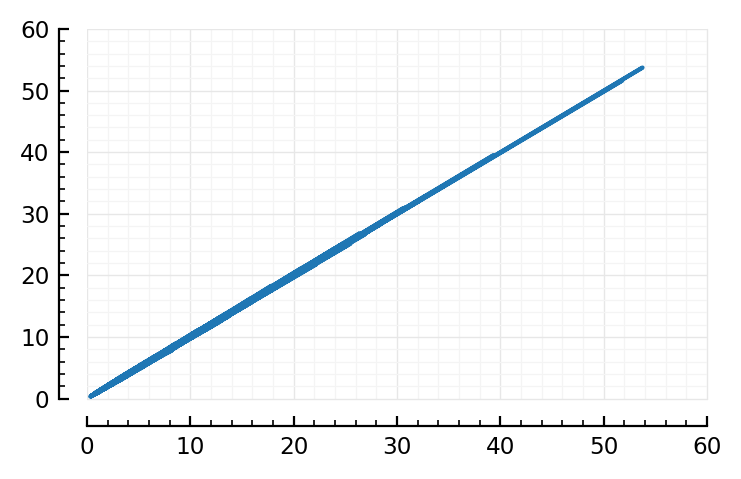

In [162]:
stipulated_firing_rates = inp.firing_rates
real_firing_rates = spikerate_.(spiketimes.(inp.inputs))
plot(stipulated_firing_rates, real_firing_rates);

Ok, check

In [157]:
fr, nid = findmax(real_firing_rates)

(53.7, 6192)

(It's an inh one)

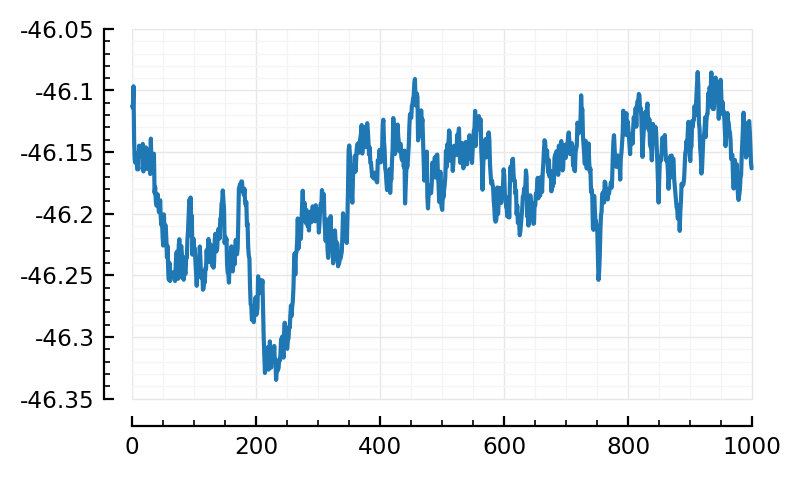

In [169]:
plotSTA(nid) = plot(calcSTA(sim, spiketimes(inp.inputs[nid])) / mV);
plotSTA(nid);

In [165]:
fr, nid_exc = findmax(real_firing_rates[1:inp.Nₑ])

(51.6, 1431)

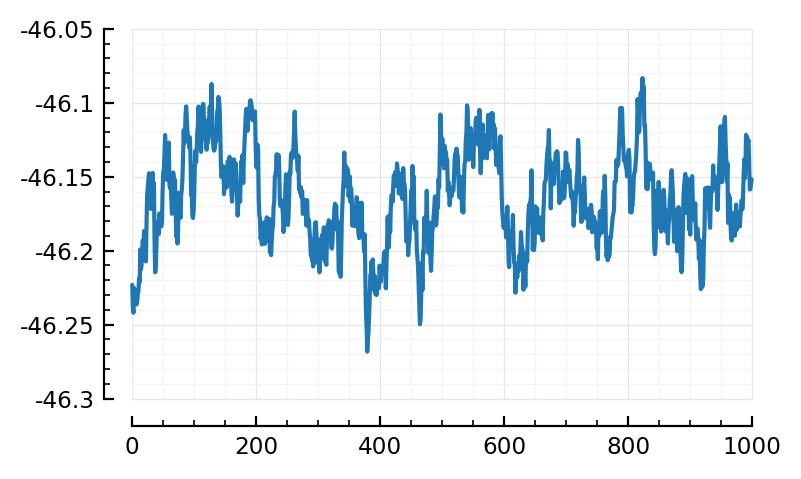

In [170]:
plotSTA(nid_exc);

Alas alas.

## What about the second to last one, N = 1600

In [179]:
i = length(Ns) - 1

5

In [180]:
Ns[i]

1600

In [173]:
sims = first.(simruns);
inps = last.(simruns);

In [177]:
firing_rates(i) = spikerate_.(spiketimes.(inps[i].inputs))

fr,ni = findmax(firing_rates(5))

(36.5, 434)

In [178]:
plotSTA(i,ni) = plot(calcSTA(sims[i], spiketimes(inps[i].inputs[ni])) / mV);

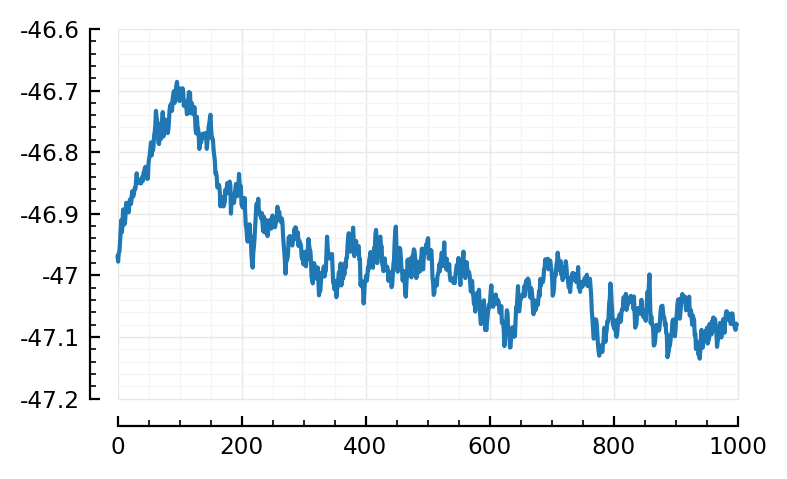

In [182]:
plotSTA(i,ni);

Ah, that's better!

In [184]:
ctr = conntestresults(5)
perftable(ctr)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Tested connections: 1600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,1063,131,,0%
Predicted type,exc,0,112,74,,60%
└,inh,0,105,115,,52%
,,,,,,
Sensitivity,,NaN%,9%,36%,,


So here it's worth doing a two-pass test:

### Two-pass test (strict ptp, then correlation)

In [189]:
ctr_strict = conntestresults(5, α=1/100)
perftable(ctr_strict)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Tested connections: 1600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,1171,166,,0%
Predicted type,exc,0,56,64,,47%
└,inh,0,53,90,,63%
,,,,,,
Sensitivity,,NaN%,4%,28%,,


In [195]:
ids = findall(ctr_strict.predtype .== :exc)
length(ids)

120

Hm although: of the 120 connections predicted 'exc', more than half are actually inh

Let's see what an average STA gives anyway

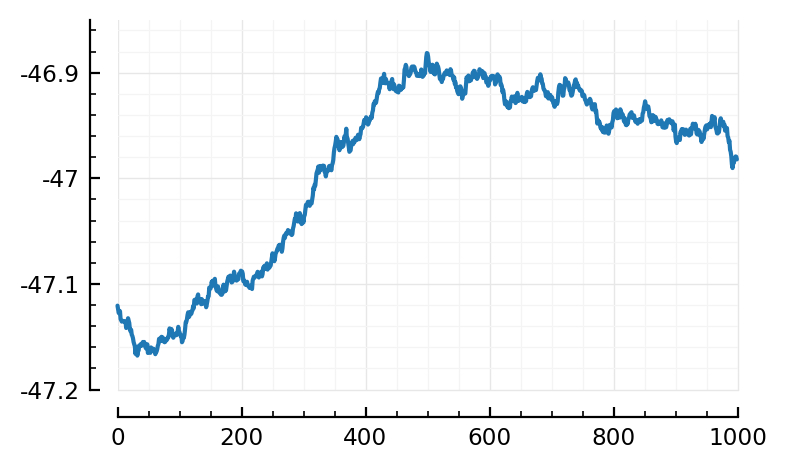

In [209]:
sim,inp = simruns[5]
STAs_predicted_exc = [calcSTA(sim, spiketimes(inp.inputs[i])) for i in ids];

template = mean(STAs_predicted_exc)

plot(template/mV);

Hm, interesting. Not the previously known STA shape.

[not furhter explored why]

Now to correlation-conntest with this

In [203]:
ctr2 = conntestresults(5, corr_test $ (; template), α = 0.05)

perftable(ctr2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Tested connections: 1600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,922,84,,0%
Predicted type,exc,0,12,236,,5%
└,inh,0,346,0,,0%
,,,,,,
Sensitivity,,NaN%,1%,0%,,


Lol it's worse.

Ok, that's cause there's more inh in template.\
(That's why STA lookd different)

So let's use inh as template

In [204]:
ids_inh = findall(ctr_strict.predtype .== :inh)
length(ids_inh)

143

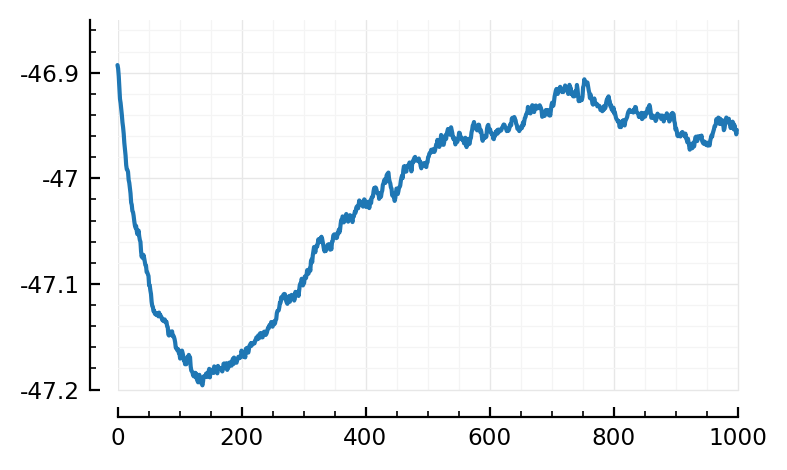

In [210]:
STAs_predicted_inh = [calcSTA(sim, spiketimes(inp.inputs[i])) for i in ids_inh];

plot(mean(STAs_predicted_inh)/mV)

template_inh = - mean(STAs_predicted_inh);  # Note the minus

That's more like it

In [212]:
ctr3 = conntestresults(5, corr_test $ (; template=template_inh), α = 0.05)

perftable(ctr3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Tested connections: 1600,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,842,58,,0%
Predicted type,exc,0,429,0,,100%
└,inh,0,9,262,,97%
,,,,,,
Sensitivity,,NaN%,34%,82%,,


Ok, not bad :)

Comparing with prev results here: 
https://tfiers.github.io/phd/nb/2022-04-28__interpolate_N_from_30_to_6000.html#plot-results

At 1600 inputs, there TPRₑ was 5%  (here 34%)\
and TPRᵢ was 21%   (here 82%)

ofc that was with just ptp test.
this is with the two phase test.

Just the ptp here:

TPRₑ 9%\
TPRᵢ 36%

so it _is_ a bit better, with the lognormal input firing

## Try two-pass test on N=6500 anyway

But, as above, with the inh as template.

In [213]:
ctr6_strict = conntestresults(6, α=1/100)
perftable(ctr6_strict)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Tested connections: 6500,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,5064,1232,,0%
Predicted type,exc,0,70,45,,61%
└,inh,0,66,23,,26%
,,,,,,
Sensitivity,,NaN%,1%,2%,,


In [217]:
ids6_inh = findall(ctr6_strict.predtype .== :inh)
length(ids6_inh)

89

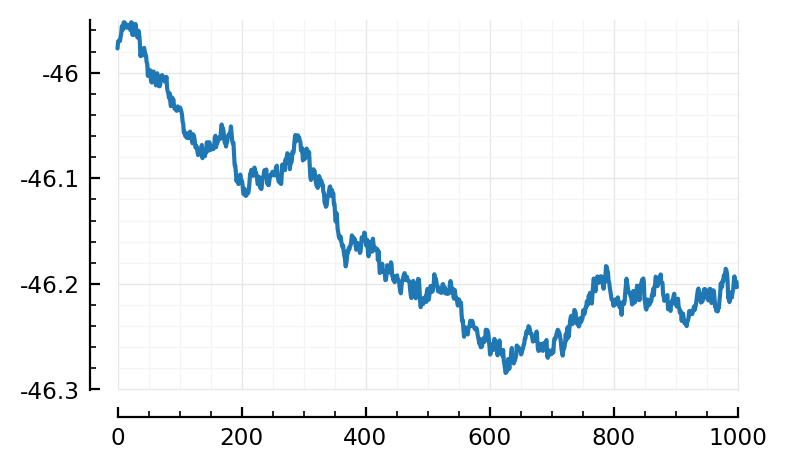

In [221]:
sim,inp = simruns[6]

STAs6_predicted_inh = [calcSTA(sim, spiketimes(inp.inputs[i]))
                        for i in ids6_inh];

avg = mean(STAs6_predicted_inh)

plot(avg/mV)

template_inh6 = - avg;

Hm. Less convincing.

(Let's try anyway)

In [222]:
ctr6_2 = conntestresults(
    6, corr_test $ (; template=template_inh6), α = 0.05
)

perftable(ctr6_2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Tested connections: 6500,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,0,4521,1021,,0%
Predicted type,exc,0,180,266,,40%
└,inh,0,499,13,,3%
,,,,,,
Sensitivity,,NaN%,3%,1%,,


Just ptp above (H2 'Eval') had

Precision\
62%\
25%

Sensitivity  3%  4%

So, this is worse.